In [1]:
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.datasets import make_classification
#%matplotlib inline
%pylab inline
import seaborn as sns
sns.set_style('whitegrid')
#%config InlineBackend.figure_format = 'svg'
pylab.rcParams['figure.figsize'] = (12.0, 5.0)

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from sklearn import svm
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_blobs
from sklearn.preprocessing import PolynomialFeatures
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

## Linear SVM reminder

Lets look for binary classification problem. Training samples are given by $\{(x_n, y_n)\}_{n=1}^N$, where $N$ — number of objects, $\boldsymbol x_n \in \mathbb{R}^d$ — feature vector of object, $y_n \in \{+1, -1\}$ — class of object.

SVM trains model for separating hyperplane:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Parameters of model — vector of weights $\boldsymbol w \in \mathbb{R}^d$ and bias $b \in \mathbb{R}$.

Training is done by solving optimisation problem:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Constraint $y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ assures that objects are correctly classified by separating hyperplane. Since in practice the sample could not be linear separable the slack variables $\xi_n$ are introduced , which weakens condition of right classification. $\| \boldsymbol w \|^2$ penalise small width of margin,  $\sum_n \xi_n$ penalise weakens of constraints. 

The solution of optimisation problem is given by $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, some of the constraints become active, i.e. become a exact equality:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Objects, corresponding to active constraints called $\textbf{support vectors}$.


Hyperparameter $C$ is responsible of balancing the width of margin and errors, made by classifier. It shows the generalizing property of the separating hyperplane - big values of $C$ corresponds to bigger generalizing ability and can lead to overfitting, if the data is well described by linear model. To select $C$ one must do cross-validation on validation set to find the best value.

### Realisation

There are two realisations of linear SVM in sklearn : [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) and [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with *linear* kernel. They build on different libraries, with solve optimisation problem *liblinear* in first case and *libsvm* in second.

Here we will use [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with *kernel='linear'*.

We generate data samples with:
- linear separable classes
- with well separable classes, but not linearly
- with non separable classes.

### The function below provides imaging and data samples creatinon. Your task is to use it according to the next exercises.

In [14]:
# From sklearn SVC examples
def svc_plotter(classifiers, name, poly_f=False):
    h = .02  # step size in the mesh
    
    # Assign this variable and set poly_f=True to look for hand made polynomial features
    # YOUR CODE HERE
    crafting = None
    
    
    X_sep, y_sep = make_blobs(n_samples=400, n_features=2, centers=2, cluster_std=1.5, random_state=42)
    linearly_separable = (X_sep, y_sep)

    X, y = make_classification(n_samples=400, n_features=2, n_redundant=0, n_informative=2,
                               random_state=231, n_clusters_per_class=1)

    rng = np.random.RandomState(2)
    X += 15 * rng.uniform(size=X.shape)
    linearly_bad_separable = (X, y)


    datasets = [linearly_separable,
                linearly_bad_separable,
                make_circles(n_samples=400, noise=0.05, random_state=42)]

    # iterate over datasets
    f, axes = plt.subplots(len(datasets), len(classifiers), figsize=(20, 20))
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=.4, random_state=42)

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        # iterate over classifiers
        index = 0
        for clf in classifiers:
            if poly_f:
                clf.fit(crafting.fit_transform(X_train), y_train)
            else:
                clf.fit(X_train, y_train)
            ax = axes[ds_cnt, index]
            index += 1

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_amin, y_max].
            if hasattr(clf, "decision_function"):
                if poly_f:
                    Z = clf.decision_function(crafting.transform(np.c_[xx.ravel(), yy.ravel()]))
                else:
                    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            #ax.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
            ax.contourf(xx, yy, Z, cmap=cm.RdBu, alpha=.8, linestyles=['--', '-', '--'],levels=[-1, 0, 1])
            ax.contour(xx, yy, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])

            #support vectors
            ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                    facecolors='none', zorder=10)

            # Plot also the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       alpha=0.6)

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xlabel("x_1")
            ax.set_ylabel("x_2")
            ax.set_title(name[index - 1])

### Task 1

Vary parameter C(in log scale) and provide a list of SVMs with linear kernel to function. name is list of strings, denoting different labels(values of c)

In [24]:
classifiers = []
name = []
# YOUR CODE HERE
svc_plotter(classifiers, name)

### Task 2

How do the value of support vectors depends on C on different datasets?(qualitatively). Then
Extract info about support vectors and plot a graph: Number of SV VS value of C for all 3 datasets declared below.

In [79]:
X_sep, y_sep = make_blobs(n_samples=400, n_features=2, centers=2, cluster_std=1.5, random_state=42)
linearly_separable = (X_sep, y_sep)

X, y = make_classification(n_samples=400, n_features=2, n_redundant=0, n_informative=2,
                           random_state=231, n_clusters_per_class=1)

rng = np.random.RandomState(2)
X += 15 * rng.uniform(size=X.shape)
linearly_bad_separable = (X, y)


datasets = [linearly_separable,
            linearly_bad_separable,
            make_circles(n_samples=400, noise=0.05, random_state=42)]

In [80]:
vectors = []
for dataset in datasets:
    # YOUR CODE HERE

As you can see, for dataset 3, there is no linear hyperplane, thus, to solve this problem, one can change feature space, in which the linear model describe dataset better.

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

For example, adding all pairwise product of features: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ transform to the space, where linear hyperplane is a quadratic form in initial feature space.

[Video with demonstration](https://youtu.be/9NrALgHFwTo)

## Task 3
add crafting variable in svc_plotter function using sklearn.preprocessing PolynomialFeatures and plot the results as above. Briefly describe the results

In [23]:
classifiers = []
name = []
# YOUR CODE HERE
svc_plotter(classifiers, name)

## Kernel SVM

![](http://i.imgur.com/bJAzRCt.png)

Linaer SVM problem, covered above, is usually called direct optimisation problem. Any direct problem has $\textbf{dual}$ problem and in some cases optimums of both problems coincide.


Dual problem for SVM is:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Vector of dual variables is being optimised $\alpha_n$. Object $x_n$ is a SV, if $\alpha_n > 0$.

The predicted label is given by:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

#### Kernel trick
Notice, that dual problem has features only as a scalar product $x^Tx'$. This observation helps us to perform kernel trick - implicitly change feature space. Instead of calculating $\phi(\boldsymbol x)$we will compute scalar product $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ called $\textbf{kernel}$. 

### Task 4

Try different SVM kernel and plot pictures as above, look what other parameters kernels have and how they affect results.
- polynomial: $k(x, x') = (x^Tx' + 1)^d$ with different $d = 2,3,\dots$
- Gaussian RBF: $k(x, x') = \exp(-\sigma\|x - x'\|^2)$

## Poly kernel

### degree=2

In [ ]:
classifiers = []
name = []
# YOUR CODE HERE
svc_plotter(classifiers, name)

### degree=5

In [ ]:
classifiers = []
name = []
# YOUR CODE HERE
svc_plotter(classifiers, name)

### degree=10

In [ ]:
classifiers = []
name = []
# YOUR CODE HERE
svc_plotter(classifiers, name)

## RBF kernel(vary gamma parameter in logscale)

In [ ]:
classifiers = []
name = []
# YOUR CODE HERE
svc_plotter(classifiers, name)

## Modelgym

You have been already told about cross-validation and hyperparamter search. Here, let's look at toy example of how you can optimise this search, making it black box optimisation problem.

Let's make a dateset, but now, with 200 features - much more real example rather than 2D examples above.

In [57]:
X_sep, y_sep = make_classification(n_samples=2000, n_features=200, n_informative=90, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sep, y_sep, test_size=.4, random_state=42)

In [58]:
# plt.figure()
# plt.scatter(X_sep[:, 0][np.where(y_sep)], X_sep[:, 1][np.where(y_sep)], c= 'r')
# plt.scatter(X_sep[:, 0][np.where((y_sep - 1)*-1)], X_sep[:, 1][np.where((y_sep - 1)*-1)], c= 'b')

Let's do cross-validaiton on grid, applying SVM with RBF kernel.

In [70]:
%%time
predictions = []
for c in np.logspace(-5, 5, 10):
    for gamma in np.logspace(-5, 5, 10):
        clf = SVC(kernel='rbf', C=c, gamma=gamma)
        clf.fit(X_train, y_train)
        predictions.append(clf.predict(X_test))

CPU times: user 1min, sys: 345 ms, total: 1min
Wall time: 1min 1s


Now, since SVM by default does not produce probability of classification, we can only use metrics, applicable to hard classification, for example accuracy and F1 score.

In [60]:
accuracy = []
f1 = []
from sklearn import metrics
for c_predict in predictions:
    accuracy.append(metrics.accuracy_score(y_test, c_predict))
    f1.append(metrics.f1_score(y_test, c_predict))

Printint the maximum of it, we get

In [71]:
print ("Accuracy:", np.max(accuracy))
print ("F1:", np.max(f1))

Accuracy: 0.86875
F1: 0.8645161290322582


Now, let's see what happens if we use _modelgym_ - Gym for predictive models). It's made to make cross-validation in smart manner, not just by looping over possible space of parameters, but rather optimising given metric function, trying to find it's maxima and corresponding parameters.

In [72]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "modelgym"))
    
from modelgym.models import SVCClassifier    
models = [SVCClassifier]

In [73]:
from sklearn.datasets import make_classification
from modelgym.utils import XYCDataset

In [64]:
dataset = XYCDataset(X_sep, y_sep)

Create optimizer.

In [74]:
from modelgym.trainers import TpeTrainer
trainer = TpeTrainer(models)

In [75]:
from modelgym.metrics import Accuracy, RocAuc, F1

Send lazy model to workout

In [76]:
%%time
trainer.crossval_optimize_params(Accuracy(), dataset, metrics=[Accuracy(), F1()])

CPU times: user 1min 40s, sys: 907 ms, total: 1min 41s
Wall time: 1min 44s


In [68]:
# dataset = XYCDataset(X_test, y_test)

Proudly look at the results

In [77]:
from modelgym.report import Report
reporter = Report(trainer.get_best_results(), dataset, [Accuracy(), F1()])
reporter.print_all_metric_results()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                           tuned
SVCClassifier  0.935496 (+0.00%)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    f1_score    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                           tuned
SVCClassifier  0.935395 (+0.00%)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



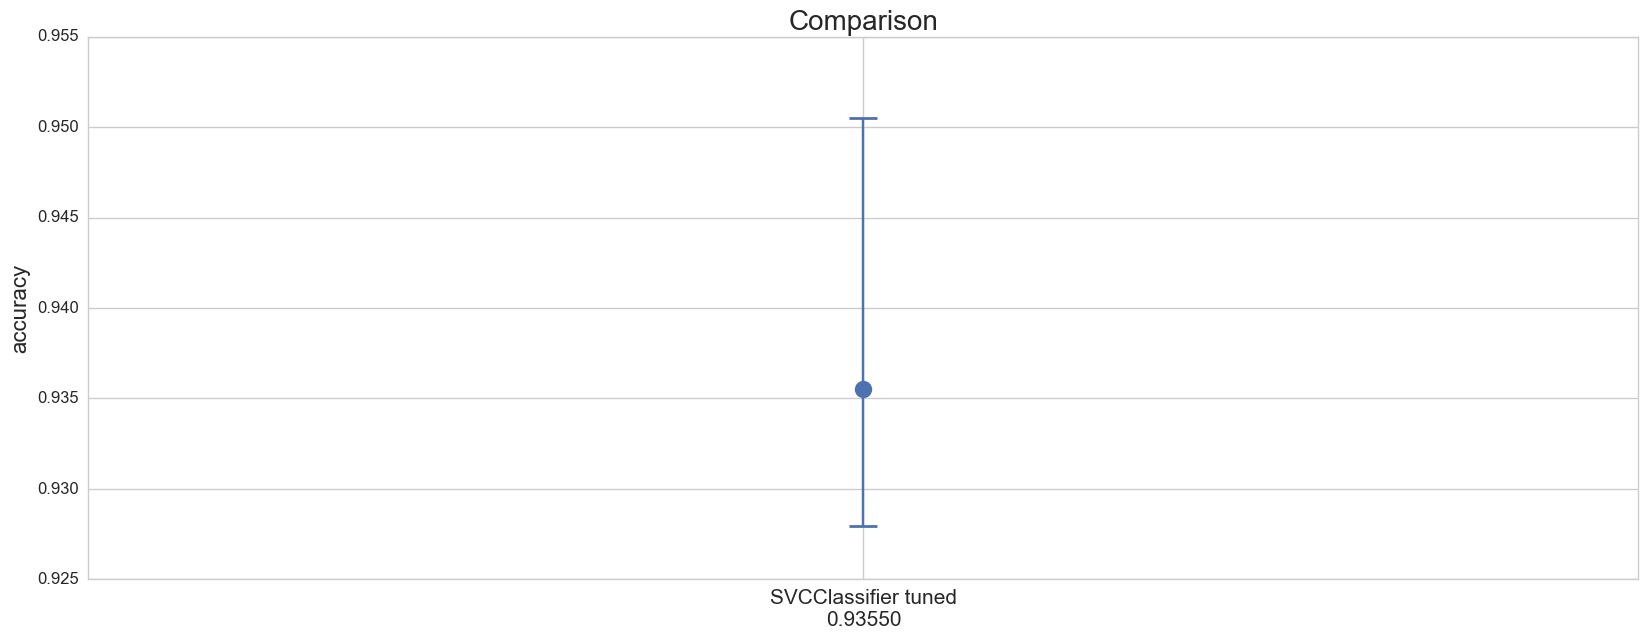


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    f1_score    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



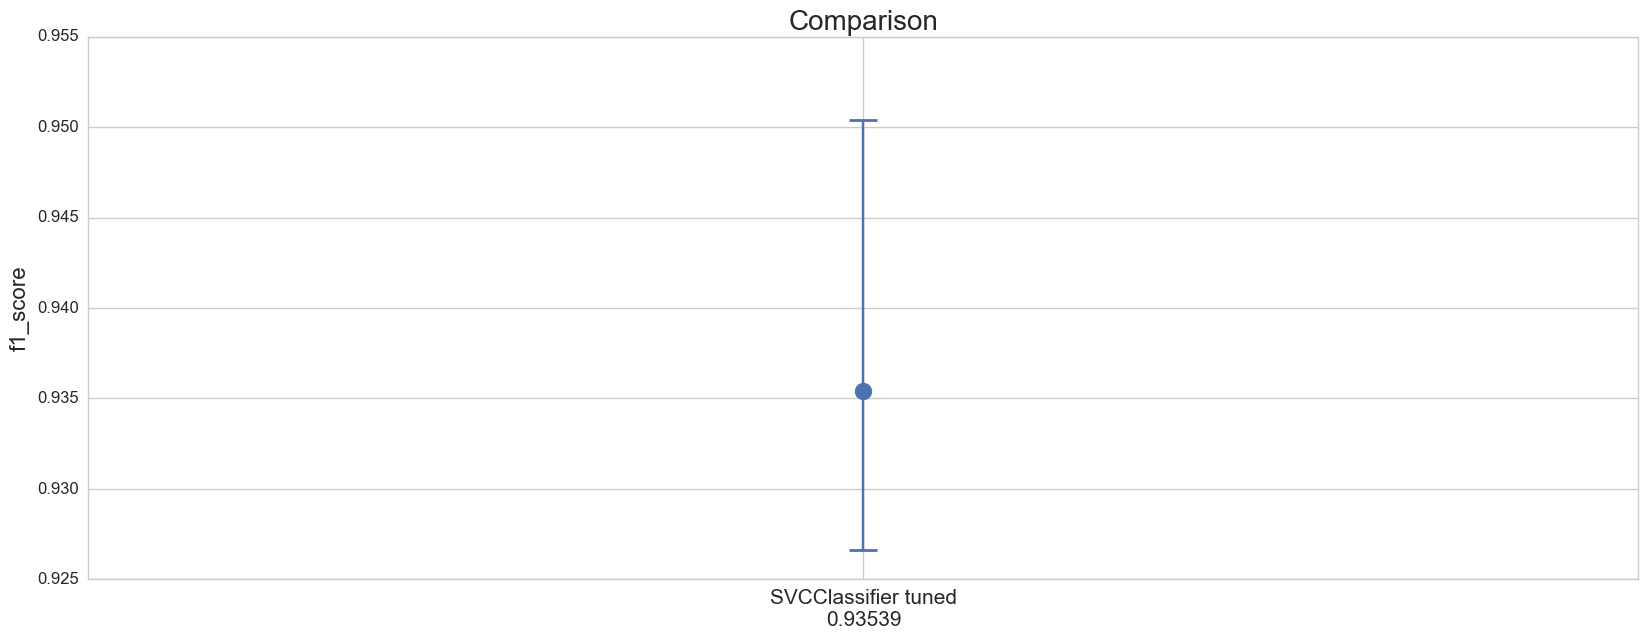

In [78]:
reporter.plot_all_metrics()

In [79]:
trainer.get_best_results()

{'SVCClassifier': {'model_space': <modelgym.utils.model_space.ModelSpace at 0x10c58c898>,
  'result': {'loss': -0.9354962158560359,
   'loss_variance': 0.010626861216768648,
   'metric_cv_results': [{'accuracy': 0.9505247376311844,
     'f1_score': 0.9503759398496241},
    {'accuracy': 0.9280359820089955, 'f1_score': 0.926605504587156},
    {'accuracy': 0.9279279279279279, 'f1_score': 0.9292035398230089}],
   'params': {'C': 100000.0, 'gamma': 0.0001291549665014884, 'kernel': 'rbf'},
   'status': 'ok'}}}

This is more or less simple example, when you have only two parameters to optimize. Image more complex ML methods, which has about 10-15 paramters to find at CV... More interesting example of modelgym on tomorrow seminar.